Повторить про собственные вектора и собственные числа

# Спектральная кластеризация (Spectral clustering)


**Спектральная кластеризация**

Спектральная кластеризация пытается получить максимальное количество профита от сложных многообразий размерности меньшей исходного пространства.


Для работы этого алгоритма нам потребуется определить матрицу похожести наблюдений (adjacency matrix). Можно это сделать таким же образом, как и для Affinity Propagation выше: $A_{i, j} = - ||x_i - x_j||^{2}$. Эта матрица также описывает полный граф с вершинами в наших наблюдениях и рёбрами между каждой парой наблюдений с весом, соответствующим степени похожести этих вершин. Для нашей выше выбранной метрики и точек, лежащих на плоскости, эта штука будет интуитивной и простой — две точки более похожи, если ребро между ними короче. Теперь нам бы хотелось разделить наш получившийся граф на две части так, чтобы получившиеся точки в двух графах были в общем больше похожи на другие точки внутри получившейся "своей" половины графа, чем на точки в "другой" половине. Формальное название такой задачи называется Normalized cuts problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Упражнения по спектральному разложению графа связей из туториала David Gleich'а: https://www.dropbox.com/s/w06niyzfe2r8y90/tutorial.pdf?dl=0.

## Часть 1. Finding a partition
Сгенерируем данные, описывающие граф, состоящий из двух независимых частей и перемешаем матрицу связей.

### Разбивка на 2 кластера

In [2]:
# задаем число вершин графа 
# (каждая вершина – отдельный актор, например, человек с политическими убеждениями республиканец или демократ)
n = 1000

# создаем массив из n номеров вершин
x = np.arange(n)

# осуществляем случайную перестановку номеров вершин
np.random.shuffle(x)

# задаем размер первой группы 
gs = 450

# отбираем gs представителей в первую группу
group1 = x[:gs]

# отбираем n-gs представителей во вторую группу
group2 = x[gs:]

# вероятность связи двух людей в первой группе
p_group1 = 0.5

# вероятность связи двух людей во второй группе
p_group2 = 0.4

# вероятность межгрупповых связей
p_between = 0.1

# инициализация матрицы смежности nxn
A = np.zeros([n, n])

In [3]:
B=np.zeros([2,3])

In [4]:
assert A.shape == (1000, 1000)

In [5]:
# подматрица смежности первой группы
A[np.ix_(group1, group1)].shape

(450, 450)

In [6]:
group1[:10]

array([ 55, 644, 370, 839,  96, 794, 804, 787, 553, 777])

In [7]:
# порождение связей в первой группы
#(бросаем случайное число от 0 до 1. Если меньше чем вероятность связи двух людей в первой группе, то связь есть. Больше - нет)
A[np.ix_(group1, group1)] = np.random.rand(gs, gs) < p_group1

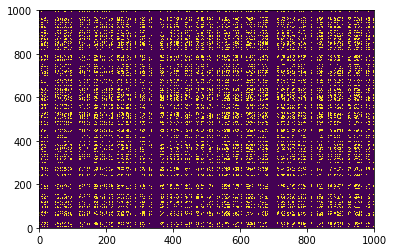

In [8]:
plt.pcolormesh(A)

In [9]:
# порождение связей во второй группе
A[np.ix_(group2, group2)] = np.random.rand(n-gs, n-gs) < p_group2

# порождение межгрупповых связей в первой группы
A[np.ix_(group1, group2)] = np.random.rand(gs, n-gs) < p_between

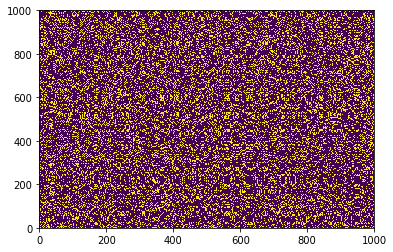

In [10]:
plt.pcolormesh(A);

In [11]:
# нам нужна симметричная матрица для моделирования отношения "дружба"
# отрезаем верхнюю треугольную матрицу
A = np.triu(A,1)

In [12]:
help(np.triu)

Help on function triu in module numpy:

triu(m, k=0)
    Upper triangle of an array.
    
    Return a copy of an array with the elements below the `k`-th diagonal
    zeroed.
    
    Please refer to the documentation for `tril` for further details.
    
    See Also
    --------
    tril : lower triangle of an array
    
    Examples
    --------
    >>> np.triu([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], -1)
    array([[ 1,  2,  3],
           [ 4,  5,  6],
           [ 0,  8,  9],
           [ 0,  0, 12]])



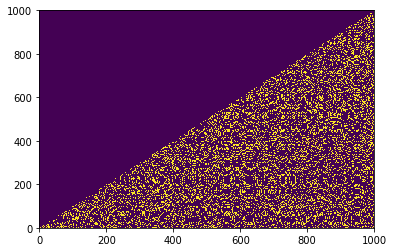

In [13]:
plt.pcolormesh(A);

In [14]:
# транспонируем и прибавляем к исходной
A = A + A.T

In [15]:
A[1,2]==A[2,1]

True

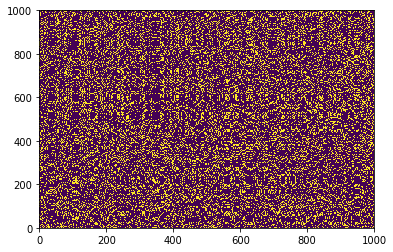

In [16]:
# визуализируем (структура на первый взгляд отсутствует)
plt.pcolormesh(A);

In [17]:
A

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

Проделаем манипуляции, описанные в пункте 1 методички. Т.е. вычислим матрицу Лапласа L=D-A, найдем ее второй наименьший собственный вектор, отсортируем его компоненты в порядке возрастания, используя найденную перестановку вершин восстановим модельную структуру в виде двух групп "друзей".

In [18]:
L=np.diag(sum(A))-A

In [19]:
#w,v=np.linalg.eig(L)

In [20]:
from scipy.sparse.linalg import eigsh

In [21]:
W,V=eigsh(L,which='SA')

In [22]:
W

array([-1.20674498e-14,  4.45837985e+01,  1.88383755e+02,  1.96673650e+02,
        1.97464050e+02,  1.98738386e+02])

In [23]:
V[:,0] #1 собственный вектор (практически единичный и не имеет смысла для нас)

array([0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162278,
       0.03162278, 0.03162278, 0.03162278, 0.03162278, 0.03162

In [24]:
V[:,1] #2 собственный вектор (практически единичный и не имеет смысла для нас)

array([-0.02577909,  0.03577448, -0.02710744,  0.0353948 ,  0.03522018,
       -0.02637502, -0.02879275, -0.02811256, -0.02507807, -0.02582135,
        0.03582765, -0.02467204,  0.0351432 , -0.02771172, -0.02700098,
       -0.02526725,  0.03418753, -0.02698305, -0.02475975, -0.02604377,
       -0.02757103,  0.03430382,  0.03498616, -0.02596307, -0.0261353 ,
        0.03525042,  0.03493129,  0.03405894,  0.03455744,  0.03341834,
        0.03568621,  0.03582616, -0.02791989,  0.03443629,  0.03470323,
        0.03513537,  0.03547892,  0.03547273,  0.03530521,  0.03510756,
        0.03426511, -0.02718156,  0.03362345,  0.03450507,  0.03483153,
        0.0347466 ,  0.03457073,  0.03429806, -0.02597094,  0.03500052,
        0.03512372,  0.03477471, -0.02814104,  0.03534292, -0.02922837,
       -0.02712628, -0.0245869 , -0.02751806, -0.02818174,  0.03424905,
        0.03523806, -0.02692359,  0.03293948, -0.02360214, -0.02559874,
       -0.02659463,  0.03377737,  0.0336446 ,  0.03584481, -0.02

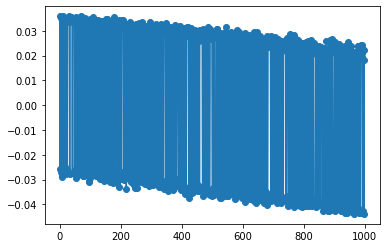

In [25]:
# Визуализируем собственный вектор 2 собственного числа. Координаты скачут как попало
plt.plot(V[:,1],"-o")

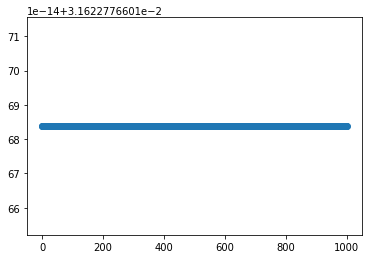

In [26]:
# собственный вектор, соответствующий 1 собственному числу
plt.plot(V[:,0],"-o")

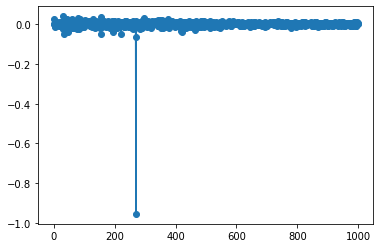

In [27]:
plt.plot(V[:,2],"-o")

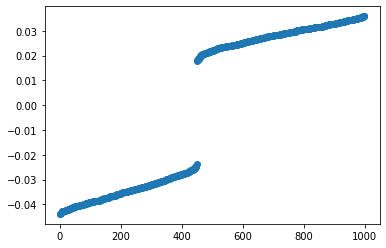

In [28]:
# Происходит резкий перепад 
plt.plot(np.sort(V[:,1]),"o")

In [29]:
idx=np.argsort(V[:,1]) # индексы элементов по возрастанию элементов собственного вектора

In [30]:
idx

array([998, 966, 937, 981, 987, 943, 941, 958, 926, 957, 879, 950, 883,
       863, 956, 921, 904, 994, 986, 897, 940, 962, 977, 970, 931, 972,
       947, 973, 925, 923, 953, 927, 944, 983, 933, 891, 934, 873, 893,
       868, 915, 967, 890, 889, 898, 907, 899, 865, 769, 841, 793, 808,
       819, 788, 844, 794, 842, 910, 880, 829, 839, 804, 896, 876, 750,
       820, 872, 681, 789, 869, 847, 936, 781, 837, 792, 870, 766, 835,
       895, 805, 845, 802, 777, 852, 881, 905, 816, 838, 823, 825, 726,
       669, 756, 644, 711, 758, 929, 725, 834, 846, 723, 807, 853, 811,
       856, 751, 715, 608, 774, 836, 884, 783, 787, 762, 817, 665, 731,
       666, 752, 724, 782, 795, 692, 773, 742, 830, 729, 636, 721, 799,
       700, 664, 698, 652, 660, 812, 680, 697, 675, 732, 641, 741, 623,
       759, 574, 703, 655, 709, 621, 616, 668, 662, 424, 743, 528, 647,
       525, 599, 704, 630, 770, 718, 642, 674, 635, 706, 624, 627, 744,
       682, 727, 553, 548, 714, 701, 579, 622, 471, 598, 678, 53

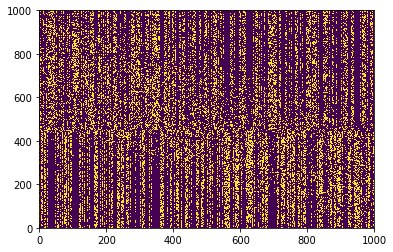

In [31]:
plt.pcolormesh(A[idx,:])

In [32]:
B=A[idx,:]

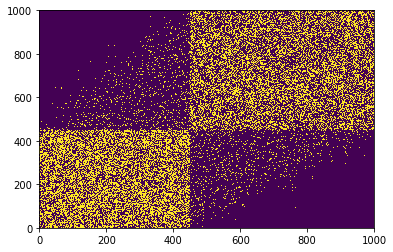

In [33]:
plt.pcolormesh(B[:,idx])

In [34]:
A

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [35]:
sum(np.dot(L,V[:,0]))

-7.220890552162018e-12

### Разбивка на 3 кластера

In [107]:
# задаем число вершин графа 
# (каждая вершина – отдельный актор, например, человек с политическими убеждениями республиканец или демократ)
n = 1000

# создаем массив из n номеров вершин
x = np.arange(n)

# осуществляем случайную перестановку номеров вершин
np.random.shuffle(x)

# задаем размер первой группы 
gs = 450


gs1 = 300

# отбираем gs представителей в первую группу
group1 = x[:gs]

# отбираем n-gs представителей во вторую группу
group2 = x[gs:gs+gs1]

# отбираем n-gs представителей в 3 группу
group3 = x[gs+gs1:]

# вероятность связи двух людей в первой группе
p_group1 = 0.5

# вероятность связи двух людей во второй группе
p_group2 = 0.4

# вероятность межгрупповых связей
p_between = 0.1

# инициализация матрицы смежности nxn
A = np.zeros([n, n])

In [108]:
B=np.zeros([2,3])

In [109]:
# подматрица смежности первой группы
A[np.ix_(group1, group1)].shape

(450, 450)

In [110]:
# порождение связей в первой группы
#(бросаем случайное число от 0 до 1. Если меньше чем вероятность связи двух людей в первой группе, то связь есть. Больше - нет)
A[np.ix_(group1, group1)] = np.random.rand(gs, gs) < p_group1

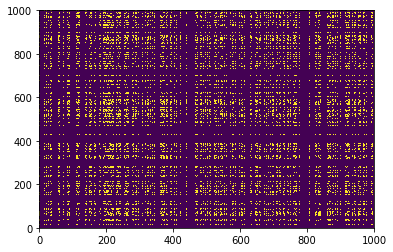

In [111]:
plt.pcolormesh(A)

In [112]:
# порождение связей во второй группе
A[np.ix_(group2, group2)] = np.random.rand(gs1, gs1) < p_group2

# порождение связей в 3 группе. Но вероятность оставим такую же как и во второй
A[np.ix_(group3, group3)] = np.random.rand(n-gs-gs1, n-gs-gs1) < p_group2

# порождение межгрупповых связей
A[np.ix_(group1, group2)] = np.random.rand(gs, gs1) < p_between
A[np.ix_(group2, group3)] = np.random.rand(gs1, n-gs-gs1) < p_between
A[np.ix_(group1, group3)] = np.random.rand(gs, n-gs-gs1) < p_between

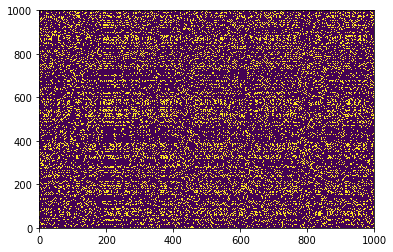

In [113]:
plt.pcolormesh(A)

In [114]:
# нам нужна симметричная матрица для моделирования отношения "дружба"
# отрезаем верхнюю треугольную матрицу
A = np.triu(A,1)

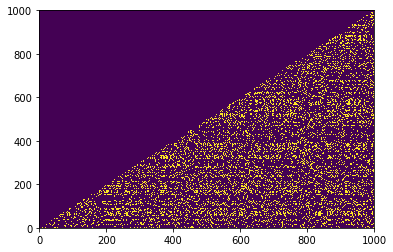

In [115]:
plt.pcolormesh(A)

In [116]:
# транспонируем и прибавляем к исходной
A = A + A.T

In [117]:
A[1,2]==A[2,1]

True

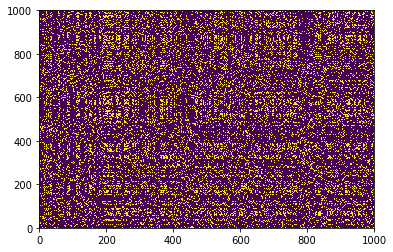

In [118]:
# визуализируем (структура на первый взгляд отсутствует)
plt.pcolormesh(A);

In [119]:
A

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [120]:
L=np.diag(sum(A))-A

In [121]:
from scipy.sparse.linalg import eigsh

In [122]:
W,V=eigsh(L,which='SA', k=10)

In [123]:
W,V

(array([5.73199369e-15, 4.10321477e+01, 4.64967724e+01, 8.85478639e+01,
        8.95322210e+01, 9.15982113e+01, 9.38459980e+01, 9.43959261e+01,
        9.50626842e+01, 9.57391192e+01]),
 array([[-3.16227766e-02, -1.95206225e-02, -1.54567796e-02, ...,
         -2.81062703e-04,  4.65272074e-04,  1.05145037e-04],
        [-3.16227766e-02,  1.02431970e-02,  5.41217680e-02, ...,
         -1.59566831e-03,  9.68897458e-05, -7.38508649e-03],
        [-3.16227766e-02, -2.16759209e-02, -1.55217163e-02, ...,
         -3.59526488e-03,  1.20527568e-03,  1.90488371e-04],
        ...,
        [-3.16227766e-02, -1.13521746e-02,  3.86971110e-02, ...,
          6.28383606e-04,  8.78174840e-04, -3.38168780e-05],
        [-3.16227766e-02,  2.74618889e-02, -7.04535018e-03, ...,
          2.02638996e-03, -1.67442769e-03, -4.35833704e-04],
        [-3.16227766e-02, -3.24792210e-02, -2.68713080e-02, ...,
          1.07362967e-04,  4.58239112e-04, -2.54298350e-04]]))

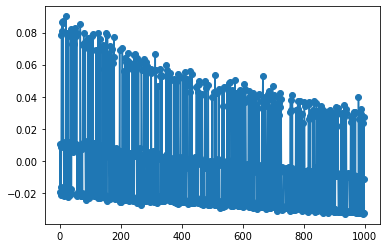

In [147]:
plt.plot(V[:,1],"-o")

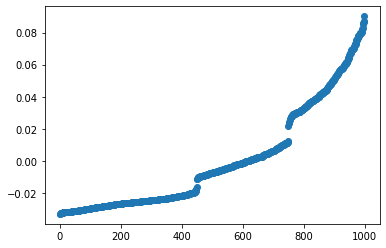

In [148]:
plt.plot(np.sort(V[:,1]),"o")

In [149]:
idx=np.argsort(V[:,1]) # индексы элементов по возрастанию элементов собственного вектора

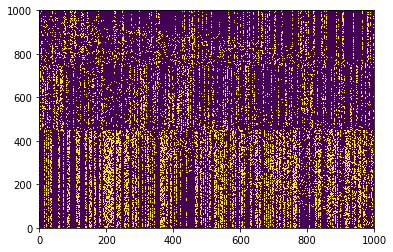

In [150]:
plt.pcolormesh(A[idx,:])

In [151]:
B=A[idx,:]

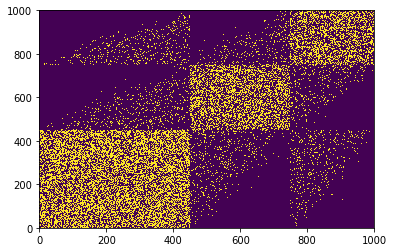

In [152]:
plt.pcolormesh(B[:,idx])

In [153]:
sum(np.dot(L,V[:,0]))

1.588285059028749e-12

## Часть 2. Meaningful Partitions of Real Datasets
"The previous example was rather compelling. However, it was also fake."

Теперь воспользуемся реальными данными от Yahoo https://www.dropbox.com/s/ii1e09dx6o2ktit/yahoo.zip?dl=0, описывающими граф связей.

In [159]:
fff = open("us.3k.2k.smat")

In [160]:
fff

<_io.TextIOWrapper name='us.3k.2k.smat' mode='r' encoding='cp1251'>

In [161]:
import os
os.getcwd()

'C:\\рекомендательные системы\\Спектральная кластерзация'

In [162]:
# считываем данные, 2000 фирм, 3000 словосочетаний, 
# 92345 связей в отношении фирма покупает словосочетание
a = np.genfromtxt('us.3k.2k.smat')
a = a.astype(int)
n, m, n_connections = a[0]

In [163]:
n, m, n_connections # отдельно 3000 словосочетаний и отдельно 2000 фирм
# Есть матрица 3000 на 2000 в которой можно вручную расставить единички там где какие фразы фирма покупала

(3000, 2000, 92345)

In [164]:
a

array([[ 3000,  2000, 92345],
       [    0,    23,     1],
       [    0,    96,     1],
       ...,
       [ 2999,  1846,     1],
       [ 2999,  1918,     1],
       [ 2999,  1939,     1]])

In [165]:
#помещаем данные в матрицу смежности n x m
A_small = np.zeros((n, m))
A_small[a[1:, 0], a[1:, 1]] = 1

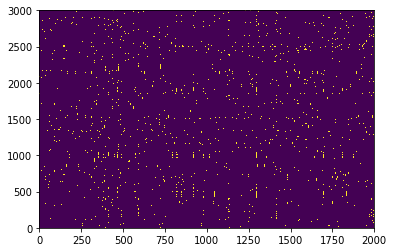

In [166]:
plt.pcolormesh(A_small)

In [167]:
sum(sum(A_small))

92345.0

In [168]:
# конструкция позволяет визуально собрать симметричную матрицу, 
# так как спектральный анализ может работать только с симметричными матрицами
A = np.vstack(
    (np.hstack(
        (np.zeros((n, n)), A_small)
    ),
     np.hstack((A_small.T, np.zeros((m, m))))
    )
)

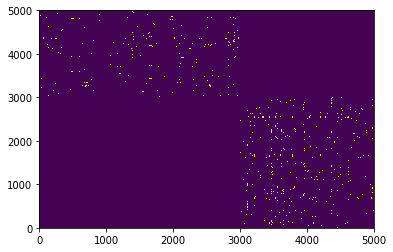

In [169]:
plt.pcolormesh(A)

In [170]:
# подсчитываем число связей как сумму всех ненулевых ячеек, т.е. единиц
sum(sum(A)) == 92345 * 2

True

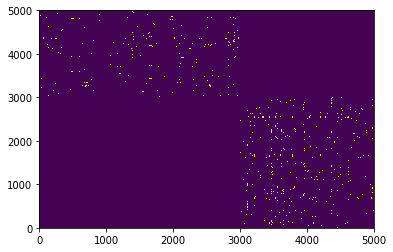

In [174]:
plt.pcolormesh(A);

In [175]:
L=np.diag(sum(A))-A

In [176]:
W,V=eigsh(L,which='SA', k=10)

In [177]:
W,V

(array([7.43417101e-15, 6.03137518e-01, 1.21876765e+00, 1.41136831e+00,
        1.48086295e+00, 1.83181136e+00, 2.02212534e+00, 2.21790432e+00,
        2.54365486e+00, 2.94006728e+00]),
 array([[ 1.41421356e-02,  7.07127265e-03, -7.03544719e-05, ...,
          1.58650712e-02, -1.93225677e-03, -3.26394302e-02],
        [ 1.41421356e-02,  6.09280000e-03, -9.33778891e-03, ...,
         -1.63926870e-04, -6.00339865e-04, -1.08721836e-03],
        [ 1.41421356e-02, -2.47068519e-02,  5.04187974e-03, ...,
          5.65772392e-04, -1.14250284e-04, -6.14442299e-04],
        ...,
        [ 1.41421356e-02,  5.96938633e-03,  2.66256489e-03, ...,
          1.98914092e-03,  6.63402396e-04,  1.60785006e-02],
        [ 1.41421356e-02,  1.11428518e-03,  5.29147377e-03, ...,
         -7.35465810e-03, -4.87262046e-04,  5.20437551e-03],
        [ 1.41421356e-02,  6.23397788e-03,  2.75856891e-02, ...,
          1.99938933e-03, -6.72568735e-04, -1.77835300e-03]]))

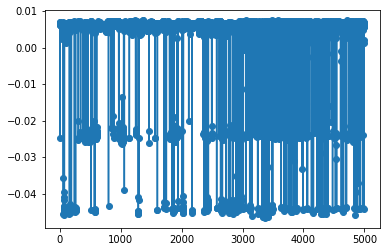

In [182]:
plt.plot(V[:,1], "-o")

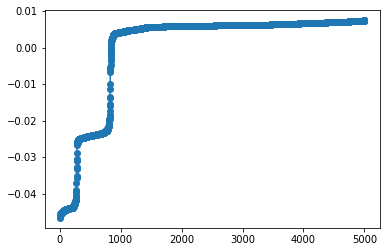

In [183]:
plt.plot(np.sort(V[:,1]), "-o")

In [189]:
idx=np.argsort(V[:,1]) # индексы элементов по возрастанию элементов собственного вектора
idx

array([3364, 3334, 3413, ..., 3480, 4719, 3581], dtype=int64)

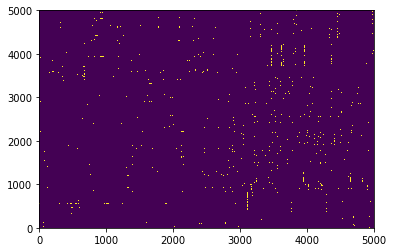

In [190]:
plt.pcolormesh(A[idx,:])

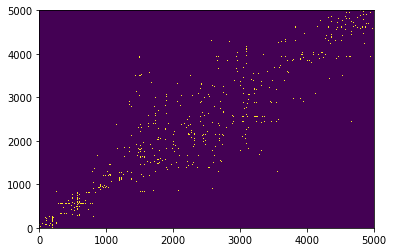

In [191]:
B = A[idx,:]
plt.pcolormesh(B[:,idx])

In [193]:
# считываем сами словосочетания с указанием их id
with open("us.3k.2k.trms", 'r') as iofile:
    labels = iofile.readlines()

In [194]:
labels

['12a1970 lexmark\n',
 '2 stacker\n',
 '21 black jack\n',
 '2nd mortgage\n',
 'acapulco hotel\n',
 'accept account card credit merchant\n',
 'accept card credit\n',
 'accept card credit online\n',
 'accessory computer\n',
 'accessory desk\n',
 'accommodation\n',
 'accommodation hotel\n',
 'accommodation las vegas\n',
 'accommodation new york\n',
 'accommodation orlando\n',
 'accommodation paris\n',
 'account card credit merchant\n',
 'account cost low merchant\n',
 'account ecommerce merchant\n',
 'account internet merchant\n',
 'account merchant\n',
 'account merchant online\n',
 'account merchant provider\n',
 'account merchant service\n',
 'acid alpha lipoic\n',
 'acid amino\n',
 'acid folic\n',
 'acne medication\n',
 'acura cl\n',
 'acyclovir\n',
 'ad banner\n',
 'ad personal\n',
 'add url\n',
 'address internet\n',
 'address web\n',
 'adds personal\n',
 'adipex\n',
 'adipex buy\n',
 'adipex buy online\n',
 'adipex cheap\n',
 'adipex diet\n',
 'adipex diet pill\n',
 'adipex line\n'

In [50]:
# Поисковые запросы среди первых 50
for i in range(50):
    if idx[i]<3000:
        print(labels[idx[i]], end = "")

adult film
cum shot video
adult amateur video
cum movie shot
amateur blow job
pussy wet
amateur sex video
fuck
hardcore video
adult picture
hot pussy
hardcore picture
nude pic
picture pussy
adult video xxx
interracial sex
amateur pussy
blow job teen
sex thumbnail
cum facial
asian porn star
blow job
anal sex video
porn star video
sex teen video
adult xxx
cum oral shot
cum facial shot
hardcore pussy
lesbian photo sex
amateur nude photo


Второй интересующий кластер находится в диапазоне от -0,02 до -0,03. Посмотрим его
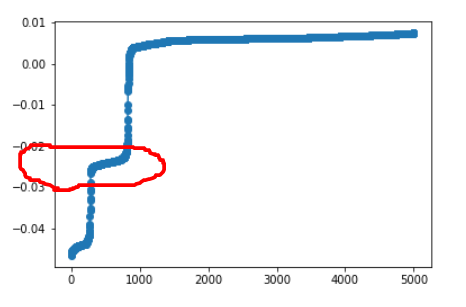

In [195]:
(V[:,1] > -0.03) & (V[:,1] < -0.02)
# True - подходят под 2 кластер - это 1
# False - не подходят под 2 кластер - это 0

array([False, False,  True, ..., False, False, False])

In [196]:
labels[2]

'21 black jack\n'

In [197]:
# id 
np.nonzero((V[:,1] > -0.03) & (V[:,1] < -0.02))

(array([   2,  300,  301,  302,  303,  337,  338,  339,  340,  341,  378,
         379,  380,  381,  382,  383,  412,  413,  418,  419,  420,  421,
         429,  430,  431,  443,  444,  445,  446,  447,  448,  449,  450,
         451,  452,  453,  454,  455,  456,  457,  458,  459,  460,  461,
         462,  465,  466,  467,  468,  469,  470,  471,  472,  473,  474,
         475,  476,  477,  478,  479,  480,  481,  482,  483,  484,  485,
         486,  487,  488,  489,  490,  491,  492,  493,  494,  495,  496,
         497,  498,  499,  500,  501,  502,  503,  504,  505,  506,  507,
         508,  509,  510,  535,  536,  537,  538,  539,  540,  541,  542,
         543,  544,  545,  546,  547,  548,  549,  550,  551,  552,  553,
         554,  555,  556,  557,  558,  559,  560,  561,  562,  563,  564,
         565,  584,  585,  586,  588,  589,  590,  591,  592,  593,  594,
         595,  596,  597,  598,  599,  600,  601,  602,  603,  604,  605,
         606,  607,  608,  609,  839, 

In [198]:
np.nonzero((V[:,1] > -0.03) & (V[:,1] < -0.02))[0][:30]

array([  2, 300, 301, 302, 303, 337, 338, 339, 340, 341, 378, 379, 380,
       381, 382, 383, 412, 413, 418, 419, 420, 421, 429, 430, 431, 443,
       444, 445, 446, 447], dtype=int64)

In [70]:
for i in np.nonzero((V[:,1] > -0.03) & (V[:,1] < -0.02))[0][:30]:
    print(labels[i], end = "")

21 black jack
baccarat
baccarat casino game
baccarat online
baccarat play
baseball bet
baseball betting
baseball betting line
baseball gambling
baseball odds
basketball bet
basketball betting
basketball betting football
basketball gambling
basketball gambling online
basketball wagering
best book online sport
best book sport
best casino
best casino gambling online
best casino internet
best casino online
best gambling online
best gambling site
best gambling site web
best online wagering
bet
bet bowl super
bet casino
bet college football


Проделайте манипуляции, описанные в пункте 3 методички. 

In [201]:
# Спектральная кластеризация с использованием sklearn.
# affinity='precomputed' - матрица посчитана заранее.
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(3, affinity='precomputed', n_init=100,
                        assign_labels='discretize')
clusters = sc.fit_predict(A) 

In [202]:
clusters[idx][:1000]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

## Часть 3. (Спектральная кластеризация на данных пользователь - фильм)

### Разбить по признаку похожесть - человек смотрел фильм или нет;

In [2]:
def loadMovieLens(type_, path='C:\рекомендательные системы\Спектральная кластерзация\ml-small'):
    if type_ == 1:    
    # Получить названия фильмов
        movies={}
        skip_first = True
        for line in open(path+'/movies.csv'):
            if skip_first:
                skip_first = False
                continue
            (id,title)=line.split(',')[0:2]
            movies[id]=title
    # Загрузить данные
        prefs={}
        skip_first = True
        for line in open(path+'/ratings.csv'):
            if skip_first:
                skip_first = False
                continue
            (user,movieid,rating,ts)=line.split(',')
            prefs.setdefault(user,{})
            prefs[user][movies[movieid]]=float(rating)
        return prefs
    elif type_ == 2:
        df = pd.read_csv(path + '/movies.csv')
        return df
    elif type_ == 3:
        df = pd.read_csv(path + '/ratings.csv')
        return df

In [3]:
# Просмотренные и оцененные пользователем фильмы
movies = loadMovieLens(3)
movies.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
new_movie_id = pd.DataFrame(data={'movieId': pd.unique(loadMovieLens(3)['movieId']),
                        'new_mov_id':np.arange(1, len(pd.unique(loadMovieLens(3)['movieId']))+1)})
new_movie_id.head(5)

,movieId,new_mov_id
0,1,1
1,3,2
2,6,3
3,47,4
4,50,5


Изначально я не планировал создавать новую таблицу с новыми индексами фильмов. Полагал, что изначальный id фильма может быть id столбца в матрице. Но значения id очень большие и между id могут быть пропуски в 10000 и т.д. И матрица получается очень большая, что python не может ее обработать. Поэтому я вытащил уникальные id фильмов. Промаркировал их от 1 до n и заново склеил с изначальной таблицей. В дальнейшем использую новый id фильма. Этот столбец с новым id и добавляется в качестве идентификатора строки в матрицу смежности.

In [5]:
max(new_movie_id.new_mov_id) == max(new_movie_id.new_mov_id)

True

In [6]:
movies = movies.merge(new_movie_id, how='left', on='movieId')

In [7]:
movies

,userId,movieId,rating,timestamp,new_mov_id
0,1,1,4.0,964982703,1
1,1,3,4.0,964981247,2
2,1,6,4.0,964982224,3
3,1,47,5.0,964983815,4
4,1,50,5.0,964982931,5
...,...,...,...,...,...
100831,610,166534,4.0,1493848402,3121
100832,610,168248,5.0,1493850091,2036
100833,610,168250,5.0,1494273047,3122
100834,610,168252,5.0,1493846352,1393


In [8]:
# 610 уникальных пользователей
n = len(pd.unique(movies['userId']))+1

In [9]:
# 9724 уникальных фильма
m = len(pd.unique(movies['movieId']))+1

In [10]:
A_small = np.zeros((n, m),dtype="float16")
A_small[np.array(movies['userId']), np.array(movies['new_mov_id'])] = 1

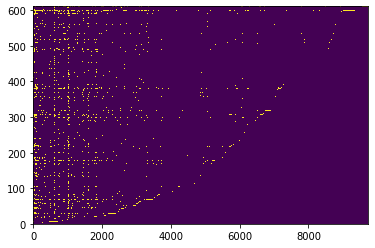

In [11]:
plt.pcolormesh(A_small)

In [12]:
# конструкция позволяет визуально собрать симметричную матрицу, 
# так как спектральный анализ может работать только с симметричными матрицами
A = np.vstack(
    (np.hstack(
        (np.zeros((n, n), dtype="float16"), A_small)
    ),
     np.hstack((A_small.T, np.zeros((m, m), dtype="float16")))
    )
)

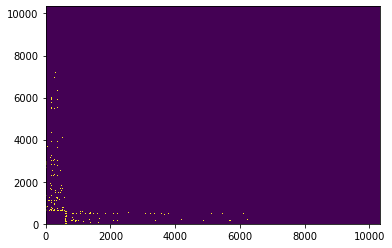

In [13]:
plt.pcolormesh(A)

In [71]:
A.dtype

dtype('float16')

In [72]:
L=np.diag(sum(A))-A

In [73]:
L = np.float64(L)

In [74]:
L

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 232.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,  29., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   1.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   1.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   1.]])

In [76]:
w,v=np.linalg.eig(L)

In [77]:
w,v

(array([9.89778541e-312+9.89029908e-312j, 6.95321458e-310+3.89817795e-321j,
        9.58981419e-321            +nanj, ...,
        0.00000000e+000+0.00000000e+000j, 0.00000000e+000+0.00000000e+000j,
        0.00000000e+000+0.00000000e+000j]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

c:\users\miste\appdata\local\programs\python\python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


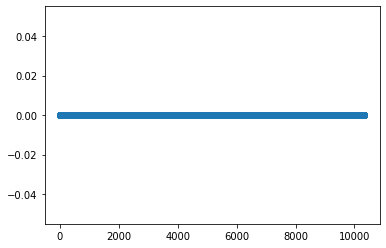

In [89]:
plt.plot(v[:,10], "-o")

c:\users\miste\appdata\local\programs\python\python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


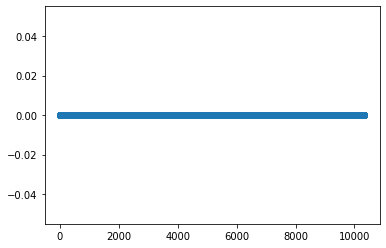

In [90]:
plt.plot(np.sort(v[:,1]), "-o")

### Если фильм понравился (оценка 4 или 5), то ставим 1, а если не понравился фильм то 0. В этом случае похожесть - это хороший выбранный фильм;